In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/home/beans/bespoke')

from models import *
from constants import *
from imports import *
from loaders import *
from train_utils import *
from rollout import RwEvaluator

torch.__version__, torch.cuda.device_count(), torch.cuda.get_device_name(torch.cuda.current_device())

('1.13.1', 2, 'NVIDIA GeForce RTX 3090')

In [2]:
import wandb
run_id = wandb.util.generate_id(); run_id

'g94z896l'

In [3]:
wandb.init(id='85ns9j23', project="carla", resume="allow")

wandb: Currently logged in as: rgilman33 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.15.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [2]:
m = EffNet().to(device) 
m.train()
sum([torch.numel(p) for p in m.parameters()]) / 1000

30484.11

In [3]:
m

EffNet(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True

In [5]:
m = try_load_state_dict(m, torch.load(f"{BESPOKE_ROOT}/models/m.torch")) # overridden when reload trainer

In [6]:
%%time
state_dict_has_nans(m.state_dict())

CPU times: user 39.3 ms, sys: 5.33 ms, total: 44.7 ms
Wall time: 51.2 ms


False

In [7]:
# m = clip_activations(m) # prints out big acts

In [8]:
%%time
from rollout import RwEvaluator
rw_evaluator = RwEvaluator(m, wandb=wandb)

CPU times: user 20 µs, sys: 7 µs, total: 27 µs
Wall time: 30.5 µs


In [9]:
model_stem = "5.25"

In [10]:
%%time

rnn_only = True
rnn_is_first = False

if rnn_only: # m cnn backbone needs to be all loaded up and ready

    if rnn_is_first:
        freeze_model(m, True)
        freeze_model(m.rnn, False)
        m.hidden_init.requires_grad = True
        m.cell_init.requires_grad = True
    else:
        freeze_model(m.backbone, True)
        
    m.backbone.train(False) # freezing bn params
    bs = 16
    bptt = 21 # these have to be multiple of Zloader's internal bptt, currently 3 for bs 32 or 7 for bs 16
    seqlen = bptt*10 # 10 works up to bptt 42
    constant_seq_aug = .0 #TODO can only do constant aug when bptt is one, currently. Fix this.
    n_workers = 5 if seqlen > 100 else 8
    # fewer than five workers we start to have to wait too long for chunk. More is better here.
    dataloader_trn = ZLoader(m, bs=bs, bptt=bptt, seqlen=seqlen, constant_seq_aug=constant_seq_aug, n_workers=n_workers)
else:
    bs = 32
    bptt = 1
    seqlen = 1
    constant_seq_aug = 0 #.9 TODO temp disabled
    n_workers = 8
    dataloader_trn = TrnLoader(bs=bs, bptt=bptt, seqlen=seqlen, constant_seq_aug=constant_seq_aug, n_workers=n_workers)
    
lr = 3e-4
m.use_rnn = rnn_only

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


waiting for chunk
waiting for chunk


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


waiting for chunk


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please 

waiting for chunk


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


waiting for chunk
waiting for chunk


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
waiting for chunk
CPU times: user 5.62 s, sys: 37 s, total: 42.6 s
Wall time: 2min 46s
Error in thread, trying again

 [Errno 2] No such file or directory: '/media/ssd2/blender_membank/dataloader_01/run_63//targets/601.npy'


Process Process-4:
Process Process-6:
Process Process-5:
Process Process-2:
Traceback (most recent call last):
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process Process-3:
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/beans/bespoke/loaders.py", line 125, in keep_chunk_filled
    time.sleep(0.1)
KeyboardInterrupt
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


In [11]:
weight_decay = .001

In [12]:
#opt = torch.optim.Adam(m.parameters(), lr=lr)
opt = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=weight_decay)

In [13]:
m.backbone.training, m.training

(False, True)

In [14]:
[(n,p.requires_grad) for (n,p) in m.named_parameters()]

[('hidden_init', True),
 ('cell_init', True),
 ('backbone.conv_stem.weight', False),
 ('backbone.bn1.weight', False),
 ('backbone.bn1.bias', False),
 ('backbone.blocks.0.0.conv_dw.weight', False),
 ('backbone.blocks.0.0.bn1.weight', False),
 ('backbone.blocks.0.0.bn1.bias', False),
 ('backbone.blocks.0.0.se.conv_reduce.weight', False),
 ('backbone.blocks.0.0.se.conv_reduce.bias', False),
 ('backbone.blocks.0.0.se.conv_expand.weight', False),
 ('backbone.blocks.0.0.se.conv_expand.bias', False),
 ('backbone.blocks.0.0.conv_pw.weight', False),
 ('backbone.blocks.0.0.bn2.weight', False),
 ('backbone.blocks.0.0.bn2.bias', False),
 ('backbone.blocks.0.1.conv_dw.weight', False),
 ('backbone.blocks.0.1.bn1.weight', False),
 ('backbone.blocks.0.1.bn1.bias', False),
 ('backbone.blocks.0.1.se.conv_reduce.weight', False),
 ('backbone.blocks.0.1.se.conv_reduce.bias', False),
 ('backbone.blocks.0.1.se.conv_expand.weight', False),
 ('backbone.blocks.0.1.se.conv_expand.bias', False),
 ('backbone.block

In [15]:
%%time
"""m.model_stem = model_stem
rw_evaluator.evaluate()"""

CPU times: user 4 µs, sys: 8 µs, total: 12 µs
Wall time: 18.4 µs


'm.model_stem = model_stem\nrw_evaluator.evaluate()'

In [16]:
# Batchnorm layer settings not overridden when reload state_dict
if True:
    for n, mm in m.backbone.named_modules():
        if type(mm) == nn.BatchNorm2d: 
            mm.momentum = .01 # effing pytorch 'momentum' is backwards
            mm.eps = 1e-5# default is 1e-5 TODO can prob revert this to default

In [17]:
for n, mm in m.backbone.named_modules():
    if type(mm) == nn.BatchNorm2d: 
        print(mm.momentum, mm.eps)

0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05
0.01 1e-05

In [18]:
trainer = Trainer(dataloader_trn, m, model_stem=model_stem, opt=opt, wandb=wandb, 
                  rw_evaluator=rw_evaluator, rnn_only=rnn_only, updates_per_epoch=(2560 if rnn_only else 5120))

In [19]:
trainer.reload_state()

Loading model from /home/beans/bespoke/models/m.torch. 
Last modified 213 min ago.
Loading opt from /home/beans/bespoke/models/opt.torch. 
Last modified 213 min ago.
Currently at epoch 51.


In [20]:
# Override state dict if necessary
# try_load_state_dict(m, torch.load(f"{BESPOKE_ROOT}/models/m4.23_e16.torch")) 

In [21]:
#trainer.current_epoch = 0

In [27]:
trainer.opt.param_groups[0]['weight_decay'] = weight_decay

In [28]:
trainer.opt.param_groups[0]['weight_decay'] # reload_state overrides our setting of lr and wd 

0.001

In [29]:
copy_cnn_params = False
if copy_cnn_params:
    m.copy_cnn_params_to_rnn() # when first trn rnn, has to be after reload_state.
    print("copied")

In [30]:
if rnn_only: # such a goddamn trap
    trainer.loss_manager.update_emas = False
    trainer.loss_manager.loss_emas['has_stop'] = 2
    trainer.loss_manager.loss_emas['stop_dist'] = .2
    trainer.loss_manager.loss_emas['lead_speed'] = 10
    trainer.loss_manager.loss_emas['te'] = .2 # manual. Bc cnn doesn't cache this. NOTE this sucks. I don't like this.

In [31]:
trainer.loss_manager.update_emas

False

In [32]:
trainer.loss_manager.loss_emas

{'has_stop': 2,
 'stop_dist': 0.2,
 'has_lead': 0.47156119266470814,
 'lead_dist': 0.20255180150269722,
 'lead_speed': 10,
 'lane_width': 6.078218277094282,
 'dagger_shift': 15.160869345160151,
 'rd_is_lined': 0.07858951836185324,
 'left_turn': 0.06171796011527849,
 'right_turn': 0.08419315544575989,
 'td': 10.0,
 'pitch': 10.0,
 'yaw': 10.0,
 'unc': 1.275633803879089,
 'te': 0.2,
 'wp_angles': 0.9745708359631701,
 'wp_curvatures': 3.6680992181724403,
 'wp_headings': 0.6988580680781801,
 'wp_rolls': 4.092933148971484,
 'wp_zs': 5.035202172490869}

In [33]:

if rnn_only:
    wandb.watch((m.fcs1_rnn, m.rnn, m.rnn_finisher.wps_head, m.rnn_finisher.aux_targets_head), 
                log="all", log_freq=1024)
else:
    wandb.watch((m.fcs1_cnn, m.cnn_finisher.wps_head, m.cnn_finisher.aux_targets_head), 
                log="all", log_freq=1024)

In [34]:
#time.sleep(60*60*1)

In [35]:
trainer.train() 

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...


 {'avg_unc': -1.66853136, 'wp_angles': 0.01307764, 'wp_headings': 0.0195953, 'wp_curvatures': 0.10088717, 'wp_rolls': 0.03950667, 'wp_zs': 0.064721, 'te': 0.17394777, 'has_stop': 1.67593447, 'stop_dist': 0.17651052, 'has_lead': 0.60186302, 'lead_dist': 0.29976182, 'lead_speed': 5.45393544, 'dagger_shift': 13.72316998, 'lane_width': 10.75899008, 'rd_is_lined': 0.06515002, 'left_turn': 0.19621666, 'right_turn': 0.10560055, 'unc': 1.36629542, 'grad_norm': 12.24178594, 'logistical/obs_consumed_per_second': 7.06457926, 'logistical/obs_generated_per_second': 38.07632094, 'logistical/slowest_runner_obs_per_sec': 2.47162427, 'logistical/data_consumption_ratio': 0.18993805, 'logistical/manual_train_pause': 0.0, 'timing/get batch from dataloader': 2.57459532, 'timing/model forward': 0.00741347, 'timing/calc losses': 0.03409779, 'timing/back

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/plotly/matplotlylib/mplexporter/exporter.py:289: MatplotlibDeprecationWarning:


The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning:

None of the inputs have requires_grad=True. Gradients will be None



waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...


 {'logistical/obs_consumed_per_second': 6.91015625, 'logistical/obs_generated_per_second': 29.32421875, 'logistical/slowest_runner_obs_per_sec': 2.0, 'logistical/data_consumption_ratio': 0.23643876, 'logistical/manual_train_pause': 0.0, 'timing/get batch from dataloader': 2.63998164, 'timing/model forward': 0.00533148, 'timing/calc losses': 0.04646106, 'timing/backwards': 0.07895517, 'timing/get worst': 1.149e-05, 'timing/logging': 0.01209418, 'timing/calc timing': 0.01260223, 'timing/trn update': 2.79544511, 'avg_unc': -1.99323491, 'wp_angles': 0.00788197, 'wp_headings': 0.01236965, 'wp_curvatures': 0.06158837, 'wp_rolls': 0.03314533, 'wp_zs': 0.06201588, 'te': 0.14452272, 'has_stop': 1.76244573, 'stop_dist': 0.08755543, 'has_lead': 0.52021644, 'lead_dist': 0.26451937, 'lead_speed': 5.11401412, 'dagger_

{'logistical/obs_consumed_per_second': 1.0, 'logistical/obs_generated_per_second': 28.0, 'logistical/slowest_runner_obs_per_sec': 2.0, 'logistical/data_consumption_ratio': 0.04307601, 'logistical/manual_train_pause': 0.0, 'timing/get batch from dataloader': 8.22154498, 'timing/model forward': 0.0082891, 'timing/calc losses': 0.04946733, 'timing/backwards': 0.25325513, 'timing/get worst': 1.55e-05, 'timing/logging': 4.82363629, 'timing/calc timing': 0.00391102, 'timing/trn update': 13.36012483}
waiting for chunk
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...


 {'avg_

waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...


 {'logistical/obs_consumed_per_second': 6.93359375, 'logistical/obs_generated_per_second': 27.35546875, 'logistical/slowest_runner_obs_per_sec': 2.0, 'logistical/data_consumption_ratio': 0.25436401, 'logistical/manual_train_pause': 1.953e-05, 'timing/get batch from dataloader': 2.80895289, 'timing/model forward': 0.0110793, 'timing/calc losses': 0.03976404, 'timing/backwards': 0.08711496, 'timing/get worst': 2.427e-05, 't

waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chun

Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting fo

waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...


 {

{'logistical/obs_consumed_per_second': 1.0, 'logistical/obs_generated_per_second': 28.0, 'logistical/slowest_runner_obs_per_sec': 2.0, 'logistical/data_consumption_ratio': 0.01844482, 'logistical/manual_train_pause': 0.0, 'timing/get batch from dataloader': 23.12088323, 'timing/model forward': 2.44075418, 'timing/calc losses': 0.06190467, 'timing/backwards': 0.0682981, 'timing/get worst': 7.39e-06, 'timing/logging': 4.78783941, 'timing/calc timing': 0.0176506, 'timing/trn update': 30.49734545}
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting f

Waiting for batch...


 {'logistical/obs_consumed_per_second': 7.546875, 'logistical/obs_generated_per_second': 28.04882812, 'logistical/slowest_runner_obs_per_sec': 2.0, 'logistical/data_consumption_ratio': 0.2706305, 'logistical/manual_train_pause': 1.953e-05, 'timing/get batch from dataloader': 2.9686562, 'timing/model forward': 0.01304105, 'timing/calc losses': 0.05638929, 'timing/backwards': 0.10046051, 'timing/get worst': 1.599e-05, 'timing/logging': 0.00732542, 'timing/calc timing': 0.01628621, 'timing/trn update': 3.162206, 'avg_unc': -2.11022989, 'wp_angles': 0.00902482, 'wp_headings': 0.01270959, 'wp_curvatures': 0.05566265, 'wp_rolls': 0.02853496, 'wp_zs': 0.054076, 'te': 0.17848309, 'has_stop': 0.85021249, 'stop_dist': 0.07045206, 'has_lead': 0.36819915, 'lead_dist': 0.20672007, 'lead_speed': 5.54854439, 'dagger_shift': 9.48179493, 'lane_width': 5.01413533, 'rd_is_lined': 0.08811799, 'left_turn': 0.10061842, 'right_turn': 0.11449181, 'unc': 1.24926681, 'grad_norm': 10.09279

{'logistical/obs_consumed_per_second': 1.0, 'logistical/obs_generated_per_second': 28.0, 'logistical/slowest_runner_obs_per_sec': 2.0, 'logistical/data_consumption_ratio': 0.03516375, 'logistical/manual_train_pause': 0.0, 'timing/get batch from dataloader': 10.20895004, 'timing/model forward': 0.00598454, 'timing/calc losses': 0.00585318, 'timing/backwards': 0.02187562, 'timing/get worst': 8.11e-06, 'timing/logging': 6.17196345, 'timing/calc timing': 0.00848985, 'timing/trn update': 16.42313123}
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
wait

Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...


 {'logistical/obs_consumed_per_second': 6.96484375, 'logistical/obs_generated

waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...


 {'logistical/obs_consumed_per_second': 6.88476562, 'logistical/obs_generated_per_second': 28.28125, 'logistical/slowest_runner_obs_per_sec': 2.0, 'logistical/data_consumption_ratio': 0.24330304, 'logistical/manual_train_pause': 1.953e-05, 'timing/get batch from dataloader': 3.02862393, 'timing/model forward': 0.0080315, 'timing/calc losses': 0.05315544, 'timing/backwards': 0.1123404, 'timing/get worst': 2.078e-05, 'timing/logging': 0.01306307, 'timing/calc timing': 0.01587356, 'timing/trn update': 3.23111819, 'avg_unc': -2.12942967, 'wp_angles': 0.00727989, 'wp_headings': 0.01380294, 'wp_curvatures': 0.05962436, 'wp_rolls': 0.03508851, 'wp_zs': 0.04965193, 'te': 0.16874578, 'has_stop': 1.01847235, 'stop_dist': 0.06412161, 'has_lead': 0.3373593, 'lead_dist': 0.2609206, 'lead_speed': 5.10318726, 'dagger_shift': 8.68482163, 'lane_width': 4.37536107, 'rd_is_lined': 0.07812541, 'left_turn': 0.12539273, 'righ

waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Wait

waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...


 {'logistical/obs_consumed_per_second': 6.8984375, 'logistical/obs_generated_per_second': 28.18359375, 'logistical/slowest_runner_obs_per_sec': 2.0, 'logistical/data_consumption_ratio': 0.2448427, 'logistical/manual_train_pause': 0.0, 'timing/get batch from dataloader': 3.02013124, 'timing/model forward': 0.01328654, 'timing/calc losses': 0.04933935, 'timing/backwards': 0.10431855, 'timing/get worst': 2.092e-05, 'timin

Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...


 {'logistical/obs_consumed_per_second': 6.90234375, 'logistical/obs_generated_per_second': 28.22851562, 'logistical/slowest_runner_obs_per_sec': 2.0, 'logistical/data_consumption_ratio': 0.24412545, 'logistical/manual_train_pause': 0.0, 'timing/get batch from dataloader': 3.04665793, 'timing/model forward': 0.01205115, 'timing/calc losses': 0.05398064, 'timing/backwards': 0.09416063, 'timing/get worst': 3.346e-05, 'timing/logging': 0.00680069, 'timing/calc timing': 0.0141258, 'timing/trn update': 3.22781918, 'avg_unc': -2.03517555, 'wp_angles': 0.00795873, 'wp_headings': 0.01552619, 'wp_curvatures': 0.07787906, 'wp_rolls': 0.03431672, 'wp_zs': 0.04578714, 'te': 0.19075334, 'has_stop': 1.74025787, 'stop_dist': 0.0

waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting

waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
W

waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting fo

Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
Waiting for batch...
waiting for chunk
Waiting for batch...
Waiting for batch...
waiting fo

In [ ]:
# The cached values from our losses ema from cnn
{'has_stop': 0.364600919867184,
 'stop_dist': 0.05096701161212571,
 'has_lead': 0.47156119266470814,
 'lead_dist': 0.20255180150269722,
 'lead_speed': 0.1,
 'lane_width': 6.078218277094282,
 'dagger_shift': 15.160869345160151,
 'rd_is_lined': 0.07858951836185324,
 'left_turn': 0.06171796011527849,
 'right_turn': 0.08419315544575989,
 'td': 10.0,
 'pitch': 10.0,
 'yaw': 10.0,
 'unc': 1.275633803879089,
 'te': 0.002,
 'wp_angles': 0.9745708359631701,
 'wp_curvatures': 3.6680992181724403,
 'wp_headings': 0.6988580680781801,
 'wp_rolls': 4.092933148971484,
 'wp_zs': 5.035202172490869}

In [30]:
"""trainer.model.model_stem = f"{trainer.model_stem}_e{trainer.current_epoch}"
trainer.rw_evaluator.evaluate()"""

0
3200
loader is done
Rollout complete!
0
3200
loader is done
Rollout complete!
0
3200
loader is done
Rollout complete!
0
loader is done
Rollout complete!
0
3200
loader is done
Stopsign approaching! 58.87
Stopsign approaching! 57.89
Stopsign approaching! 56.9
Stopsign approaching! 56.12
Stopsign approaching! 55.26
Stopsign approaching! 54.52
Stopsign approaching! 53.77
Stopsign approaching! 53.1
Stopsign approaching! 52.28
Stopsign approaching! 51.41
Stopsign approaching! 50.73
Stopsign approaching! 50.1
Stopsign approaching! 49.4
Stopsign approaching! 48.76
Stopsign approaching! 48.15
Stopsign approaching! 47.51
Stopsign approaching! 46.92
Stopsign approaching! 46.23
Stopsign approaching! 45.61
Stopsign approaching! 45.02
Stopsign approaching! 44.42
Stopsign approaching! 43.87
Stopsign approaching! 43.25
Stopsign approaching! 42.7
Stopsign approaching! 42.09
Stopsign approaching! 41.56
Stopsign approaching! 41.11
Stopsign approaching! 40.55
Stopsign approaching! 40.06
Stopsign approac

In [30]:
img = trainer.img_for_viewing

In [31]:
img_d = unprep_img(img)

In [32]:
img_d.shape

(32, 1, 360, 1440, 3)

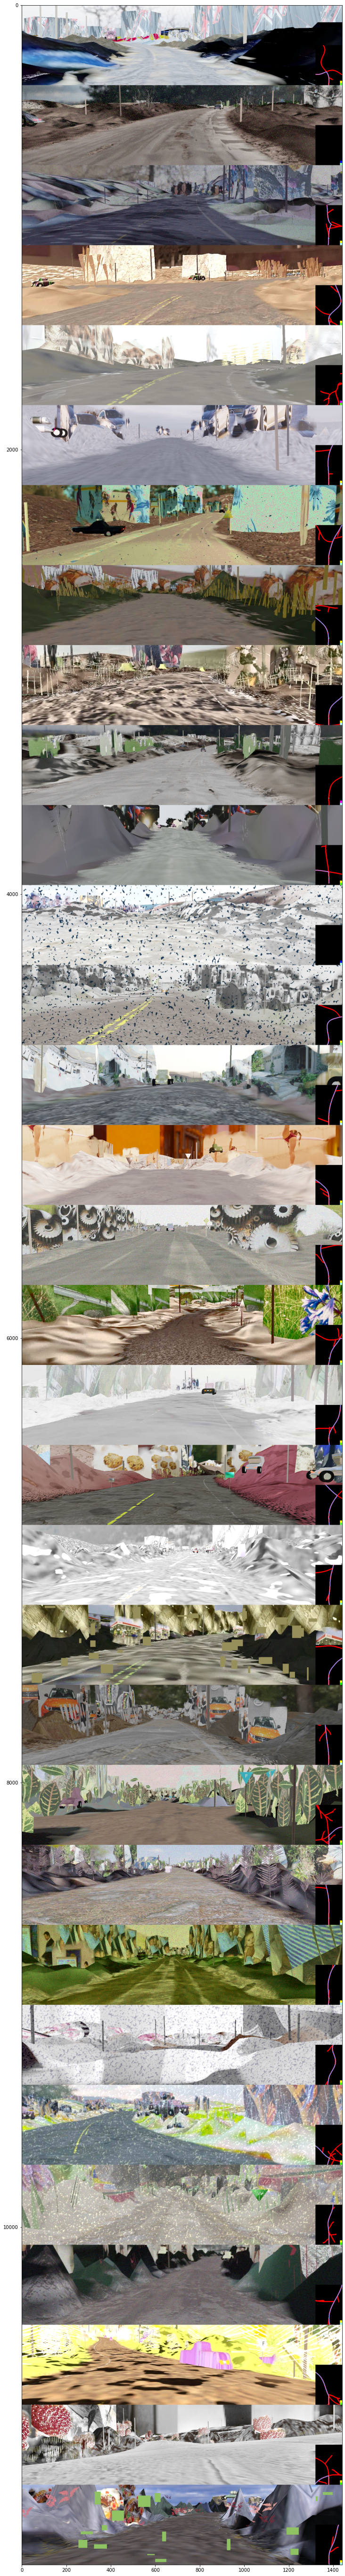

In [33]:
plt.figure(figsize=(20,100))
plt.imshow(np.concatenate(img_d[:,0,:,:,:],0))

In [27]:
t = torch.randn((3,4))
(~torch.isfinite(t)).any()

tensor(False)

In [34]:
for n,p in m.named_parameters():
    if 'bn' in n:
        print(p.max().item(), p.min().item())


Error in callback <function _WandbInit._resume_backend at 0x7f5cb546edc0> (for pre_run_cell):


Exception: The wandb backend process has shutdown

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
t

Exception: The wandb backend process has shutdown

In [21]:
t = torch.randn(3,4,5)

In [29]:
(t>.5) | (t <.1)

tensor([[[False,  True, False,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]],

        [[ True,  True, False,  True,  True],
         [False, False,  True, False,  True],
         [ True,  True, False,  True,  True],
         [ True,  True,  True,  True,  True]],

        [[False,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True],
         [ True, False,  True,  True,  True]]])

In [22]:

t[0,0,0] = torch.inf

In [23]:
t

tensor([[[    inf, -0.7854, -1.3716,  0.8498, -0.0986],
         [ 0.3141, -1.5963, -0.3781, -1.1632,  0.0405],
         [-0.0689, -0.9696,  1.4334,  1.0205,  2.2483],
         [ 1.2481, -0.8255, -0.5951, -0.0256,  0.2744]],

        [[ 0.6463,  1.3897,  0.8417, -0.3971, -1.4846],
         [ 0.3036, -0.4071, -0.0882, -0.6457,  0.2220],
         [ 1.5495,  0.6217, -0.4204,  0.3186,  0.4908],
         [-2.7397, -2.3005,  1.9402, -0.5320, -1.1312]],

        [[ 0.2612,  0.7503, -0.6469,  0.5444, -0.6493],
         [-1.0282, -1.1678, -0.1762,  1.1714,  0.2500],
         [ 0.6518, -0.5325, -1.2205,  0.8746,  0.5583],
         [ 0.3824, -0.7756,  0.8413,  0.3293, -1.3277]]])

In [24]:
t.max()

tensor(inf)

In [20]:
AUX_TARGET_PROPS

['has_stop',
 'stop_dist',
 'has_lead',
 'lead_dist',
 'lead_speed',
 'dagger_shift',
 'lane_width',
 'rd_is_lined',
 'left_turn',
 'right_turn']

In [20]:
trainer.loss_manager.loss_emas

{'has_stop': 0.6581827152218972,
 'stop_dist': 0.1914074304465102,
 'has_lead': 0.6045025000545183,
 'lead_dist': 0.18079276826857715,
 'lead_speed': 0.8834656769419045,
 'lane_width': 4.096574170043749,
 'dagger_shift': 2.512469867257369,
 'rd_is_lined': 0.10581200184235365,
 'left_turn': 0.08856740587054233,
 'right_turn': 0.07401701428385941,
 'td': 10.0,
 'pitch': 10.0,
 'yaw': 10.0,
 'unc': 117.34792707051348,
 'te': 0.002,
 'wp_angles': 0.0859911379087128,
 'wp_angles_i': 4.15318218310992,
 'wp_curvatures': 0.7827851002866839,
 'wp_curvatures_i': 17.866540970943753,
 'wp_headings': 0.12228421566478304,
 'wp_headings_i': 2.901144808827211,
 'wp_rolls': 4.211842307760256,
 'wp_rolls_i': 0.13459417300430104,
 'wp_zs': 5.043518468202303,
 'wp_zs_i': 1.1309414719989206}

In [20]:
m.hidden_init, m.cell_init

(Parameter containing:
 tensor([[[ 0.0015, -0.0488, -0.0292,  ..., -0.0560, -0.0283,  0.0664]]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[[-0.3869,  0.0330,  0.0708,  ..., -0.0204,  0.3181, -0.2530]]],
        device='cuda:0', requires_grad=True))

In [21]:
m.training, m.backbone.training 

(True, False)

In [22]:
set_trainer_should_stop(False)

In [28]:
{k:trainer.loss_manager.loss_emas["wp_angles"]/trainer.loss_manager.loss_emas[k] for k,v in trainer.loss_manager.loss_emas.items()}

{'has_stop': 29.734797363340526,
 'stop_dist': 87.87280383313023,
 'has_lead': 40.201898525296386,
 'lead_dist': 127.76564504863305,
 'lead_speed': 0.34846566491395553,
 'lane_width': 3.809900606793288,
 'dagger_shift': 4.134576796863424,
 'rd_is_lined': 16457.381372040072,
 'left_turn': 125.55969474655697,
 'right_turn': 283.74133223646584,
 'td': 0.015300805875045518,
 'pitch': 0.015300805875045518,
 'yaw': 0.015300805875045518,
 'unc': 0.11512757866420895,
 'te': 61.54656219577027,
 'wp_angles': 1.0,
 'wp_angles_i': 0.240031243936724,
 'wp_curvatures': 0.16382346075192508,
 'wp_curvatures_i': 0.003522151816451157,
 'wp_headings': 0.5183519273228973,
 'wp_headings_i': 0.005565440760627469,
 'wp_rolls': 0.027721036050055964,
 'wp_rolls_i': 8.663331955712781,
 'wp_zs': 0.00020285505128895626,
 'wp_zs_i': 0.0035411505624853203}

In [23]:
{'has_stop': 0.005145757574225003,
 'stop_dist': 0.001741244754645775,
 'has_lead': 0.0038059908701619494,
 'lead_dist': 0.0011975680840668381,
 'lead_speed': 0.4390907746627964,
 'lane_width': 0.04016064316156499,
 'dagger_shift': 0.0370069456362572,
 'rd_is_lined': 9.297229935401817e-06,
 'left_turn': 0.0012186080816722507,
 'right_turn': 0.0005392519219686348,
 'td': 10.0,
 'pitch': 10.0,
 'yaw': 10.0,
 'unc': 1.329030459302299,
 'te': 0.002486053701322257,
 'wp_angles': 0.15300805875045517,
 'wp_angles_i': 0.6374505928519476,
 'wp_curvatures': 0.9339813604728601,
 'wp_curvatures_i': 1.44164213359285,
 'wp_headings': 0.2951818073498582,
 'wp_headings_i': 1.49253209788985,
 'wp_rolls': 5.519564942456264,
 'wp_rolls_i': 0.017661571729288113,
 'wp_zs': 754.2728553133405,
 'wp_zs_i': 43.208571917673005


import sys
sys.getsizeof(trainer.loss_manager.loss_emas)

1176

In [16]:
torch.save(trainer.model.state_dict(), f"{BESPOKE_ROOT}/models/m{trainer.model_stem}_e{trainer.current_epoch}.torch")

In [16]:
m.training

Error in callback <function _WandbInit._resume_backend at 0x7f62ef023160> (for pre_run_cell):


Exception: The wandb backend process has shutdown

True

Error in callback <function _WandbInit._pause_backend at 0x7f62e3b863a0> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [ ]:
trainer.opt.param_groups[0]['lr'] = 3e-4

In [28]:
snr

0.15067877149872744



 {'logistical/obs_consumed_per_second': 38.2265625, 'logistical/obs_generated_per_second': 85.1328125, 'logistical/slowest_runner_obs_per_sec': 5.3125, 'logistical/data_consumption_ratio': 0.45004667, 'logistical/manual_train_pause': 0.0, 'timing/get batch from dataloader': 0.00400971, 'timing/model forward': 0.19439457, 'timing/calc losses': 0.00539116, 'timing/backwards': 1.11790375, 'timing/get worst': 0.00264816, 'timing/logging': 0.01570235, 'timing/calc timing': 0.01359244, 'timing/trn update': 1.35364565, 'wp_angles': 0.01003864, 'wp_curvatures': 0.04547036, 'wp_headings': 0.01048879, 'wp_rolls': 0.52840137, 'wp_zs': 0.09037566, 'has_stop': 0.01459547, 'stop_dist': 0.00825622, 'has_lead': 0.01966284, 'lead_dist': 0.00662124, 'lead_speed': 16.11909485, 'dagger_shift': 0.14152849, 'lane_width': 0.12975717, 'rd_is_lined': 0.01347083, 'pitch': 4.037e-05, 'yaw': 4.98e-05, 'unc': 1.57641983, 'logistical/max_param': 32.69097137, 'logistical/lr': 0.0006, 'logistical/mins_since_slowest

In [9]:
%%time

rnn_only = True

if rnn_only: # m cnn backbone needs to be all loaded up and ready
    #freeze_model(m, True)
    #unfreeze_part_of_model(m, "rnn")
    freeze_model(m.backbone, True)
    m.backbone.train(False) # freezing bn params
    bs = 16
    bptt = 14 #35 #8 #7
    seqlen = bptt*5 # needs to be mult of 7
    constant_seq_aug = .0 #TODO can only do constant aug when bptt is one, currently. Fix this.
    dataloader_trn = ZLoader(m, bs=bs, bptt=bptt, seqlen=seqlen)
else:
    bs = 32
    bptt = 1
    seqlen = 1
    constant_seq_aug = .9
    dataloader_trn = TrnLoader(bs=bs, bptt=bptt, seqlen=seqlen, constant_seq_aug=constant_seq_aug)

Launching 3 loader workers


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated.

Got first chunk
CPU times: user 1.1 s, sys: 5.72 s, total: 6.83 s
Wall time: 45.2 s


Process Process-3:
Process Process-4:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/beans/bespoke/loaders.py", line 133, in make_chunks
    time.sleep(.1)
  File "/home/beans/miniconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 1

In [25]:
set_should_stop(True)

In [10]:
%%time

eval_rw(rw_dataloader, m, wandb) # will log directly to wandb

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


CPU times: user 14.3 s, sys: 417 ms, total: 14.7 s
Wall time: 14 s
